### **Classifier experiment**

In [ ]:
import os
import numpy as np
import librosa
import torch
import torchaudio
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools

# Add the parent directory to the Python path
import sys
import os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import loss function
from texstat.functions import *
import texstat.torch_filterbanks.filterbanks as fb

def stats_model(segment, coch_fb, mod_fb, downsampler, N_moments, alpha):
    return statistics_mcds_feature_vector(segment, coch_fb, mod_fb, downsampler, N_moments, alpha).detach().numpy()

def load_audio_embeddings(folder_path, model_function, sample_rate=44100, segment_size=2**16, num_segments=20, *args, **kwargs):
    """
    Load audio embeddings for training.

    Args:
        folder_path (str): Path to dataset with subfolders for each class.
        model_function (callable): Function to extract embeddings (must accept a raw audio segment).
        segment_size (int, optional): Size of the audio segment to extract. Defaults to 2**16.
        num_segments (int, optional): Number of segments per class. Defaults to 20.
        *args: Positional arguments to pass to model_function.
        **kwargs: Keyword arguments to pass to model_function.

    Returns:
        np.ndarray: Feature matrix (X).
        np.ndarray: One-hot encoded labels (y).
        dict: Mapping of class indices to class names.
    """
    X, y = [], []
    class_labels = {}

    # number_of_classes = len(os.listdir(folder_path))
    # segments_per_class = num_segments // number_of_classes

    for idx, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        class_labels[idx] = class_folder

        wav_files = [f for f in os.listdir(class_path) if f.endswith(".wav")]
        if not wav_files:
            continue
        
        for _ in range(num_segments):
            selected_file = random.choice(wav_files)  # Pick a new random file each time
            # wav_files.remove(selected_file)  # Remove to avoid reselecting the same file
            
            file_path = os.path.join(class_path, selected_file)
            audio, sr = librosa.load(file_path, sr=sample_rate, mono=True)
            total_samples = len(audio)
            
            if total_samples < segment_size:
                num_repeats = (segment_size // total_samples) + 1  # Compute required repeats
                hann_window = np.hanning(total_samples)  # Create a smooth window
                audio_repeated = np.zeros(num_repeats * total_samples)
                # Apply overlap-add with windowing
                for i in range(num_repeats):
                    start_idx = i * total_samples // 2  # 50% overlap
                    audio_repeated[start_idx:start_idx + total_samples] += audio * hann_window
                audio = audio_repeated
                total_samples = len(audio)
            
            start = random.randint(0, total_samples - segment_size)
            segment = audio[start:start + segment_size]
            segment = torch.tensor(segment, dtype=torch.float32)

            # Generate embedding and store it
            embedding = model_function(segment, *args, **kwargs)

            # If there is a NaN in the embedding, skip this segment
            if np.isnan(embedding).any():
                continue
            X.append(embedding)
            y.append(idx)

    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    return X, y, class_labels

def train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, solver='adam')
    classifier.fit(X_train, np.argmax(y_train, axis=1))
    
    y_pred = classifier.predict(X_test)
    y_test_labels = np.argmax(y_test, axis=1)
    
    # Accuracy
    print("Accuracy:", accuracy_score(y_test_labels, y_pred))
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred, target_names=[class_labels[i] for i in class_labels]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Extract class names as a list
    class_names = [class_labels[i] for i in range(len(class_labels))]

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return classifier


### **1. TexStat Classification**

### **1.1. Hand-curated dataset**

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

     bubbles       1.00      1.00      1.00        39
        fire       1.00      1.00      1.00        48
    keyboard       1.00      1.00      1.00        35
        rain       1.00      1.00      1.00        38
       water       1.00      1.00      1.00        45
        wind       1.00      1.00      1.00        35

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Confusion Matrix:
[[39  0  0  0  0  0]
 [ 0 48  0  0  0  0]
 [ 0  0 35  0  0  0]
 [ 0  0  0 38  0  0]
 [ 0  0  0  0 45  0]
 [ 0  0  0  0  0 35]]


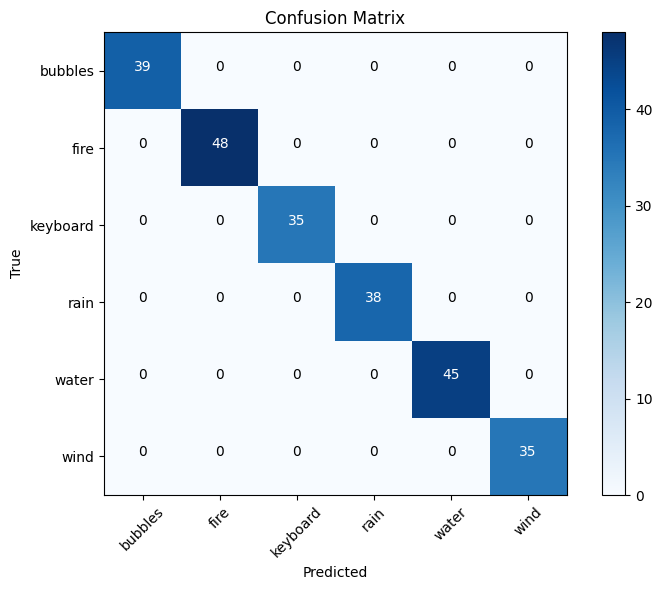

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [ ]:
# Stats parameters
sr            = 44100
frame_size    = 2**16
N_filter_bank = 16
M_filter_bank = 6
N_moments     = 4
alpha         = torch.tensor([100, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_audio_embeddings(
    folder_path="../../datasets/hand_curated/",
    model_function=stats_model,
    sample_rate =sr,
    segment_size=2**16, 
    num_segments=200, # model parameters from here
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)

### **1.2. Boreillysegmented16K_small dataset**

Accuracy: 0.7325
Classification Report:
              precision    recall  f1-score   support

         arp       1.00      0.03      0.05        36
      braids       0.73      0.68      0.70        47
      briads       0.81      0.76      0.79        46
          em       0.76      0.44      0.56        36
        ichT       0.56      1.00      0.72        34
        moog       0.54      0.74      0.62        34
      nether       0.67      0.88      0.76        33
     reaktor       0.98      1.00      0.99        44
         skr       0.66      0.77      0.71        48
     stochos       1.00      0.95      0.98        42

    accuracy                           0.73       400
   macro avg       0.77      0.73      0.69       400
weighted avg       0.78      0.73      0.70       400

Confusion Matrix:
[[ 1  2  0  1  7  5  8  0 12  0]
 [ 0 32  6  0  2  4  2  0  1  0]
 [ 0  7 35  0  0  3  0  0  1  0]
 [ 0  1  0 16 14  4  0  0  1  0]
 [ 0  0  0  0 34  0  0  0  0  0]
 [ 0  2  1  0  0 2

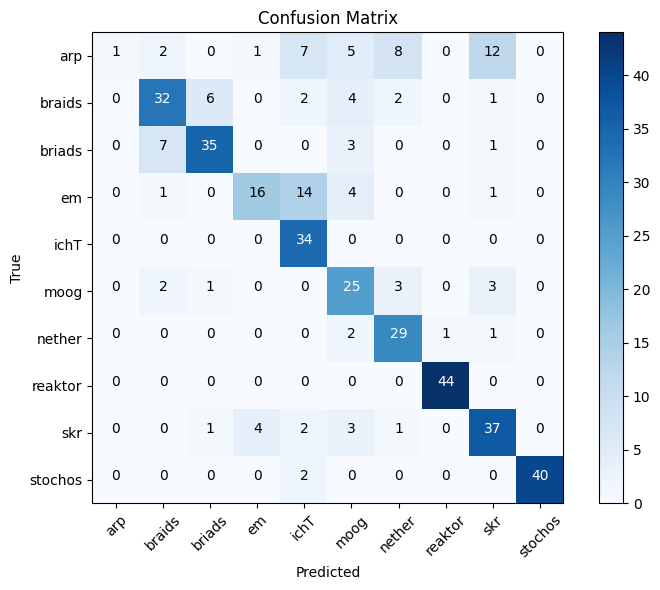

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [3]:
# Stats parameters
sr            = 44100
frame_size    = 2**16
N_filter_bank = 16
M_filter_bank = 6
N_moments     = 4
alpha         = torch.tensor([100, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_audio_embeddings(
    folder_path="../../datasets/boreillysegmented16K_small/",
    model_function=stats_model,
    sample_rate =sr,
    segment_size=frame_size, 
    num_segments=200,
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)

### **1.3. Syntex dataset**

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

    applause       1.00      1.00      1.00        37
        chua       1.00      1.00      1.00        48
     peepers       1.00      1.00      1.00        41
        pops       1.00      1.00      1.00        38
     tapping       1.00      1.00      1.00        47
        wind       1.00      1.00      1.00        29

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Confusion Matrix:
[[37  0  0  0  0  0]
 [ 0 48  0  0  0  0]
 [ 0  0 41  0  0  0]
 [ 0  0  0 38  0  0]
 [ 0  0  0  0 47  0]
 [ 0  0  0  0  0 29]]


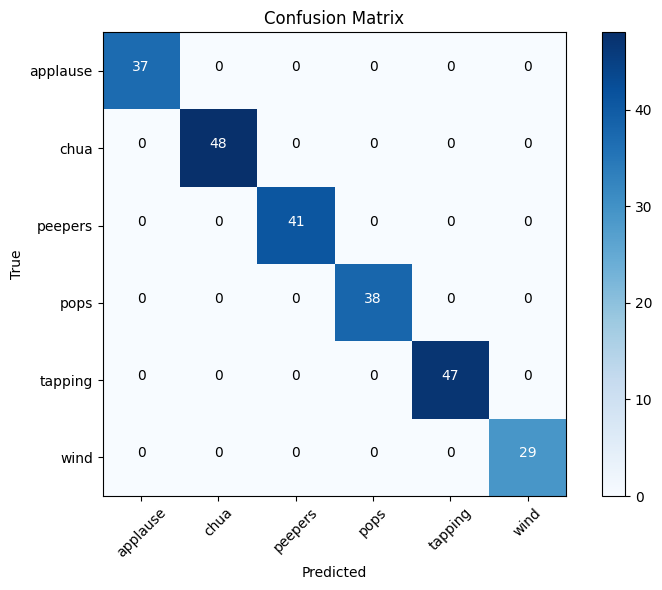

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)

In [4]:
# Stats parameters
sr            = 44100
frame_size    = 2**16
N_filter_bank = 16
M_filter_bank = 6
N_moments     = 4
alpha         = torch.tensor([100, 1, 1/10, 1/100])
beta          = torch.tensor([1, 1, 1, 1, 1])
new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
downsampler = torchaudio.transforms.Resample(sr, new_sr)
coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
mod_fb  = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

# Embeddings computation for dataset
X, y, class_labels = load_audio_embeddings(
    folder_path="../../datasets/syntex_dataset/",
    model_function=stats_model,
    sample_rate =sr,
    segment_size=2**16, 
    num_segments=200,
    coch_fb=coch_fb,
    mod_fb=mod_fb,
    downsampler=downsampler,
    N_moments=N_moments,
    alpha=alpha
)

train_and_evaluate_mlp(X, y, class_labels, test_size=0.2, random_seed=42)